In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import folium
import joblib
import matplotlib.pyplot as plt

In [2]:
#Simulating 100 village points
np.random.seed(0)
longitudes = np.random.uniform(36.5, 37.5, 100)
latitudes = np.random.uniform(-1.0, 0.0, 100)
geometries = [Point(xy) for xy in zip(longitudes, latitudes)]

#Creating a geospatial DataFrame with 6 features and 100 samples each
villages = gpd.GeoDataFrame({
    'elevation': np.random.uniform(80, 500, 100),          # meters
    'distance_to_river': np.random.uniform(0.1, 10, 100),   # km
    'rainfall_last_7days': np.random.uniform(0, 350, 100),  # mm
    'soil_permeability': np.random.uniform(0.1, 1.0, 100),  # 0 (clay) - 1 (sand)
    'ndvi': np.random.uniform(-0.1, 0.9, 100),              # vegetation index
    'slope': np.random.uniform(0, 30, 100)                  # degrees
}, geometry=geometries, crs="EPSG:4326")

villages.head()

,elevation,distance_to_river,rainfall_last_7days,soil_permeability,ndvi,slope,geometry
0,210.954270,9.074899,140.440825,0.379343,0.074658,11.196479,POINT (37.04881 -0.32218)
1,372.464265,7.763069,325.251996,0.435731,0.227988,6.685915,POINT (37.21519 -0.72999)
2,238.655773,3.398137,34.865226,0.572473,0.580349,2.415960,POINT (37.10276 -0.26481)
3,155.433545,0.902904,330.855537,0.775536,-0.036792,2.559328,POINT (37.04488 -0.03781)
4,90.365066,4.131688,304.320986,0.400157,0.507249,6.641893,POINT (36.92365 -0.75125)


In [3]:
#Calculate percentiles to guide thresholds
elev_thresh = villages['elevation'].quantile(0.7)           # 70th percentile
dist_thresh = villages['distance_to_river'].quantile(0.7)   # 70th percentile
rain_thresh = villages['rainfall_last_7days'].quantile(0.4) # 40th percentile
soil_thresh = villages['soil_permeability'].quantile(0.8)   # 80th percentile

def classify_flood_risk(row):
    if (row['elevation'] < elev_thresh and
        row['distance_to_river'] < dist_thresh and
        row['rainfall_last_7days'] > rain_thresh and
        row['soil_permeability'] < soil_thresh):
        return "High"
    else:
        return "Low"

villages['flood_risk'] = villages.apply(classify_flood_risk, axis=1)

print(villages['flood_risk'].value_counts())
villages.head()

flood_risk
Low     79
High    21
Name: count, dtype: int64


,elevation,distance_to_river,rainfall_last_7days,soil_permeability,ndvi,slope,geometry,flood_risk
0,210.954270,9.074899,140.440825,0.379343,0.074658,11.196479,POINT (37.04881 -0.32218),Low
1,372.464265,7.763069,325.251996,0.435731,0.227988,6.685915,POINT (37.21519 -0.72999),Low
2,238.655773,3.398137,34.865226,0.572473,0.580349,2.415960,POINT (37.10276 -0.26481),Low
3,155.433545,0.902904,330.855537,0.775536,-0.036792,2.559328,POINT (37.04488 -0.03781),High
4,90.365066,4.131688,304.320986,0.400157,0.507249,6.641893,POINT (36.92365 -0.75125),High


In [4]:
villages.describe()

,elevation,distance_to_river,rainfall_last_7days,soil_permeability,ndvi,slope
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,294.045433,4.780299,174.903109,0.555606,0.385520,14.059830
std,127.344241,2.832146,105.958577,0.272378,0.280475,9.018078
min,85.559480,0.213132,4.212678,0.102433,-0.080877,0.041500
25%,180.189736,2.515902,87.208939,0.345440,0.163914,6.674909
50%,291.829173,4.619607,153.665290,0.570215,0.363840,12.773510
75%,411.118085,7.272791,265.608790,0.765944,0.599491,22.884772
max,495.942358,9.598390,348.040276,0.998166,0.899278,29.756710


In [5]:
#Separating features from target and dropping geometry for model building
X = villages[['elevation', 'distance_to_river', 'rainfall_last_7days', 'soil_permeability', 'ndvi', 'slope']]
y = villages['flood_risk']

#Splitting data into test and train sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Training the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

#Prediction and evaluation
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['Low', 'High']))

              precision    recall  f1-score   support

         Low       1.00      0.33      0.50         3
        High       0.89      1.00      0.94        17

    accuracy                           0.90        20
   macro avg       0.95      0.67      0.72        20
weighted avg       0.91      0.90      0.88        20



In [6]:
#Adding predictions to GeoDataFrame
villages['prediction'] = model.predict(X)

#Defining colors
risk_colors = {"High": "red", "Low": "green"}

In [7]:
#Visualizing with folium
m = folium.Map(location=[-0.5, 37.0], zoom_start=8)
for _, row in villages.iterrows():
    color = risk_colors[row['prediction']]
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=5,
        color=color,
        fill=True,
        fill_opacity=0.8
    ).add_to(m)

#Saving the map
m.save("flood_prediction_map.html")

In [8]:
#Saving the prediction model
joblib.dump(model, 'model.pkl')

['model.pkl']

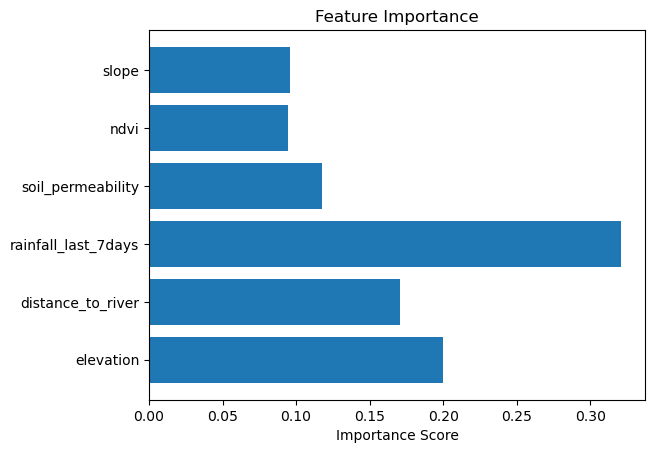

In [9]:
#Feature importance
features = X.columns
importances = model.feature_importances_

plt.barh(features, importances)
plt.title("Feature Importance")
plt.xlabel("Importance Score")
plt.show()